# Find failed words from parameters
In which we set a lower threshold for the "failed" condition using the parameters we've computed from the piecewise and logistic distribution fitting.

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load frequency for sanity checks
tf = pd.read_csv('../../data/frequency/2013_2016_tf_norm_log.tsv', sep='\t', index_col=0)

## Test discrete piecewise parameter optimization
Something's off with the piecewise parameters...we should debug this.

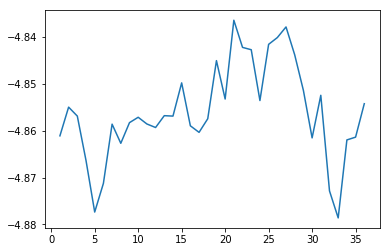

In [3]:
test_word = 'sorta'
test_series = tf.loc[test_word, :]
plt.plot(pd.np.arange(1,len(test_series)+1,1), test_series)
plt.show()

In [4]:
from scipy.stats import linregress
from sklearn.metrics import r2_score
s = 25
X = pd.np.arange(1, len(test_series)+1, 1)
m1, b1, _, _, _ = linregress(X[:s], test_series[:s])
m2, b2, _, _, _ = linregress(X[s:], test_series[s:])
y1_pred = m1*X[:s] + b1
y2_pred = m2*X[s:] + b2
y_pred = pd.np.concatenate([y1_pred, y2_pred])
r2 = r2_score(test_series, y_pred)
print('y1=%.3E*x + %.3f'%(m1, b1))
print('y2=%.3E*x + %.3f'%(m2, b2))
print('R2=%.3E'%(r2))

y1=9.042E-04*x + -4.868
y2=-2.588E-03*x + -4.776
R2=4.846E-01


## Load data

In [5]:
piecewise_params = pd.read_csv('../../data/frequency/2013_2016_tf_norm_log_2_piecewise_discrete.tsv', sep='\t', index_col=0, header=0)
N = 36
piecewise_params_valid = piecewise_params[(piecewise_params.loc[:, 't'] > 0) & (piecewise_params.loc[:, 't'] < N)]
print('%d valid series'%(piecewise_params_valid.shape[0]))
print(piecewise_params_valid.head())
print(piecewise_params_valid.median(axis=0))

99963 valid series
         t        m1        m2         b        R2
just   3.0  0.000275 -0.000261 -2.266512  0.203569
like  25.0  0.000195 -0.000272 -2.299323 -0.055207
can    7.0  0.002810 -0.000260 -2.415319  0.496094
one   27.0 -0.000517 -0.000142 -2.450930  0.824565
get    4.0  0.002783 -0.000029 -2.469688  0.272360
t     14.000000
m1     0.001004
m2    -0.000514
b     -6.668942
R2     0.327022
dtype: float64


35558 piecewise candidates
0.300181932618


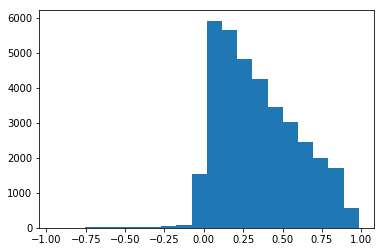

In [6]:
piecewise_params_grow_decline = piecewise_params_valid[(piecewise_params_valid.loc[:, 'm1'] > 0) &
                                                       (piecewise_params_valid.loc[:, 'm2'] < 0)]
print('%d piecewise candidates'%(piecewise_params_grow_decline.shape[0]))
print(pd.np.percentile(piecewise_params_grow_decline.loc[:, 'R2'], 50))
plt.hist(piecewise_params_grow_decline.loc[:, 'R2'], 20)
plt.show()

In [7]:
# sorta is buried too far down!! but how do we get it without compromising everything else?
test_word = 'sorta'
print(piecewise_params_valid.loc[test_word])

t     27.000000
m1     0.000976
m2    -0.000634
b     -4.867335
R2     0.494155
Name: sorta, dtype: float64


In [99]:
piecewise_params_fail = piecewise_params[(piecewise_params.loc[:, 'm1'] > 0) &
                                         (piecewise_params.loc[:, 'm2'] < 0)]
cutoff_pct = 95
piecewise_r2_cutoff = pd.np.percentile(piecewise_params_fail.loc[:, 'R2'], cutoff_pct)
print(piecewise_r2_cutoff)
piecewise_params_fail = piecewise_params_fail[piecewise_params_fail.loc[:, 'R2'] >= piecewise_r2_cutoff]
piecewise_params_fail.sort_values('R2', inplace=True, ascending=False)
print('%d potential fail words'%(piecewise_params_fail.shape[0]))

0.817174529902
1778 potential fail words


In [100]:
print(piecewise_params_fail.head(20))

               t        m1        m2         b        R2
keks        18.0  0.099356 -0.002392 -8.188397  0.985142
csgolounge  10.0  0.349313 -0.003336 -9.494655  0.981867
gofundme    23.0  0.067455 -0.001525 -7.459256  0.980533
gfycat       7.0  0.534409 -0.014307 -9.327465  0.976068
little       2.0  0.000032 -0.001832 -3.099887  0.974297
memed       33.0  0.054024 -0.004735 -7.695905  0.974259
judgmental   2.0  0.019845 -0.008085 -5.347350  0.971911
gah          2.0  0.012871 -0.008269 -5.370777  0.971352
terribly     4.0  0.002271 -0.003103 -4.707355  0.971133
patreon     16.0  0.160791 -0.002747 -8.186165  0.970677
itt          4.0  0.025387 -0.010817 -4.772015  0.968183
rekts       18.0  0.128854 -0.002115 -9.076885  0.967398
paging      30.0  0.019778 -0.001888 -5.975587  0.967266
weebs       30.0  0.046330 -0.000584 -7.622069  0.966710
skrub       13.0  0.107716 -0.013351 -7.862140  0.966240
fdev        27.0  0.130393 -0.007904 -9.562193  0.965055
leterally    6.0  0.017797 -0.0

In [101]:
piecewise_fail_candidates = piecewise_params_fail.index.tolist()

### Logistic

In [9]:
# same thing but with logistic
logistic_params = pd.read_csv('../../data/frequency/2013_2016_tf_norm_logistic_params.tsv', sep='\t', index_col=0)
N = 36
logistic_params_valid = logistic_params[(logistic_params.loc[:, 'loc'] > 0) &
                                        (logistic_params.loc[:, 'loc'] < N)]
print('%d valid logistic candidates'%(logistic_params_valid.shape[0]))
print(logistic_params_valid.head())

99729 valid logistic candidates
            loc     scale        R2
just  15.004176  7.921824 -0.675196
like  17.854175  7.871330 -0.581077
can   17.355896  6.778966  0.255427
one    8.869916  6.444788  0.512292
get   18.705448  6.864276  0.208423


In [10]:
cutoff_pct = 99
logistic_r2_cutoff = pd.np.percentile(logistic_params_valid.loc[:, 'R2'], cutoff_pct)
print('logistic R2 cutoff = %.3f'%(logistic_r2_cutoff))
logistic_params_fail = logistic_params_valid[logistic_params.loc[:, 'R2'] >= logistic_r2_cutoff]
print('%d valid logistic candidates'%(logistic_params_fail.shape[0]))
print(logistic_params_fail.head())

logistic R2 cutoff = 0.824
998 valid logistic candidates
              loc     scale        R2
max     26.418651  5.068906  0.874237
wrote    1.812639  2.062033  0.902602
trump   32.123220  2.615133  0.900826
hunter  24.363479  5.157777  0.828841
bernie  30.968358  3.207631  0.885849


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [29]:
logistic_fail_candidates = logistic_params_fail.index.tolist()

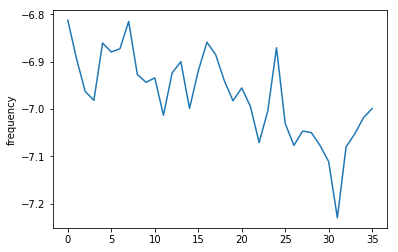

In [151]:
N = 36
time_steps = range(0, N)
test_word = 'coffeeshops'
plt.plot(time_steps, tf.loc[test_word])
plt.ylabel('frequency')
plt.show()

## Combine candidate lists

In [30]:
print('%d piecewise candidates'%(len(piecewise_fail_candidates)))
print('%d logistic candidates'%(len(logistic_fail_candidates)))
combined_fail_candidates = set(piecewise_fail_candidates) | set(logistic_fail_candidates)
print('%d combined candidates'%(len(combined_fail_candidates)))

1232 piecewise candidates
998 logistic candidates
2130 combined candidates


In [31]:
print('\n'.join(sorted(combined_fail_candidates)[:10]))

aaaand
aaaannnd
aaayyy
abathur
abbrev
abend
aber
acasis
aciv
acro


Let's write these to file and come back after we're done annotating.

In [33]:
candidate_out_file = '../../data/frequency/word_lists/2013_2016_fail_candidate_list.tsv'
with open(candidate_out_file, 'w') as candidate_out:
    for c in sorted(combined_fail_candidates):
        candidate_out.write('%s,\n'%(c))

Initial tests find that this method doesn't generate enough interesting piecewise stuff.

## Generate candidate scores

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
piecewise_params_scored = piecewise_params_valid.copy()
piecewise_params_scored.loc[:, 'score'] = (piecewise_params_scored.loc[:, 'm1'].apply(lambda x: int(x>0))*
                                           piecewise_params_scored.loc[:, 'm2'].apply(lambda x: int(x<0))*
                                           piecewise_params_scored.loc[:, 'R2'])
# piecewise_params_scored.loc[:, 'score'] = (piecewise_params_scored.loc[:, 'k1'].apply(lambda x: int(x>0))*
#                                            piecewise_params_scored.loc[:, 'k2'].apply(lambda x: int(x<0))*
#                                            piecewise_params_scored.loc[:, 'R2'])
piecewise_params_scored.loc[:, 'score'] = scaler.fit_transform(piecewise_params_scored.loc[:, 'score'])
piecewise_params_scored.sort_values('score', inplace=True, ascending=False)
piecewise_params_scored.head()

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,t,m1,m2,b,R2,score
keks,18.0,0.099356,-0.002392,-8.188397,0.985142,3.860825
csgolounge,10.0,0.349313,-0.003336,-9.494655,0.981867,3.846172
gofundme,23.0,0.067455,-0.001525,-7.459256,0.980533,3.840201
gfycat,7.0,0.534409,-0.014307,-9.327465,0.976068,3.820220
little,2.0,0.000032,-0.001832,-3.099887,0.974297,3.812292


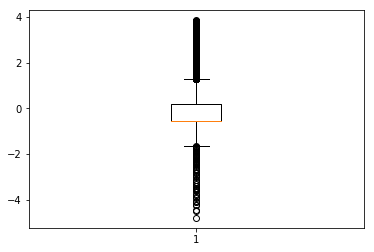

In [105]:
plt.boxplot(piecewise_params_scored.loc[:, 'score'])
plt.show()

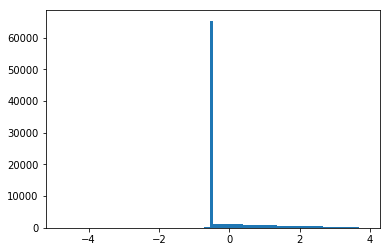

In [106]:
plt.hist(piecewise_params_scored.loc[:, 'score'], bins=100)
plt.show()

In [107]:
test_word = 'sorta'
print(piecewise_params_scored.loc[test_word])

t        27.000000
m1        0.000976
m2       -0.000634
b        -4.867335
R2        0.494155
score     1.663585
Name: sorta, dtype: float64


There we go! That could put `sorta` back on top.

In [84]:
print(piecewise_params_valid.loc[:, 'R2'].median())
print(len(piecewise_params_valid[piecewise_params_valid.loc[:, 'R2'] >= piecewise_params_valid.loc[:, 'R2'].median()]))

0.374131439881
43801


In [156]:
cutoff_pct = 85
piecewise_cutoff_score = pd.np.percentile(piecewise_params_scored.loc[:, 'score'], cutoff_pct)
print(piecewise_cutoff_score)
piecewise_score = piecewise_params_scored[piecewise_params_scored.loc[:, 'score'] >= piecewise_cutoff_score]
print(piecewise_score.loc[:, 'R2'].min())
piecewise_scored_fail_candidates = piecewise_score.index.tolist()
print('%d candidates discovered from score function'%(len(piecewise_scored_fail_candidates)))
print('%d candidates total'%(len(set(piecewise_scored_fail_candidates) | set(logistic_fail_candidates))))
print(','.join(sorted(piecewise_scored_fail_candidates)[:75]))

1.06780337115
0.361026707783
14995 candidates discovered from score function
15665 candidates total
aaaah,aaaannd,aaaannnd,aaaannnddd,aaah,aaargh,aaaw,aadmi,aahh,aaj,aalewis,aam,aang,aap,aarons,aback,abarth,abathur,abbas,abbasid,abbott,abbrev,abd,abdullah,abend,aber,abhi,abkhazia,ablative,able,abm,abner,abnormally,abolisher,abomasnow,abot,abotu,abras,absently,absentmindedly,absol,absolument,absorb,absorbed,abstergo,abstractions,abv,abyssea,abysses,abzan,academic,academically,acadian,acara,acasis,accelerant,accelgor,accentuating,accept,acceptance,accepts,accessory,accidently,accolade,accommodating,accompanies,accustom,aced,aceh,acer,acestream,acetaminophen,acetyl,acf,acg


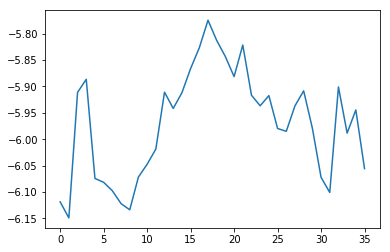

In [113]:
N = tf.shape[1]
X = pd.np.arange(0,N,1)
plt.plot(X, tf.loc['aced'])
plt.show()

Recombine candidates and write to new file.

In [90]:
# old code
# combined_score_fail_candidates = set(piecewise_scored_fail_candidates) | set(logistic_fail_candidates)
# candidate_out_file = '../../data/frequency/word_lists/2013_2016_fail_scored_candidate_list.tsv'
# with open(candidate_out_file, 'w') as candidate_out:
#     for c in sorted(combined_score_fail_candidates):
#         candidate_out.write('%s,\n'%(c))

In [159]:
# this time, with data from piecewise discrete parameter fit
candidate_file = '../../data/frequency/word_lists/2013_2016_fail_scored_candidate_list.tsv'
old_candidate_data = pd.read_csv(candidate_file, 
                                 sep=',', index_col=0, header=None)
new_candidates = sorted((set(piecewise_scored_fail_candidates) | set(logistic_fail_candidates)) - set(old_candidate_data.index.tolist()))
old_candidates = set(old_candidate_data.index.tolist()) - (set(piecewise_scored_fail_candidates) | set(logistic_fail_candidates))
overlap_candidates = (set(old_candidate_data.index.tolist()) & set(piecewise_scored_fail_candidates) | 
                      set(old_candidate_data.index.tolist()) & set(logistic_fail_candidates))
print('%d new candidates'%(len(new_candidates)))
print('%d old candidates'%(len(old_candidates)))
new_candidate_data = old_candidate_data.loc[overlap_candidates]
new_candidate_data = new_candidate_data.append(pd.DataFrame(['?']*len(new_candidates), index=new_candidates, columns=[1]))
print(new_candidate_data.head())
print('%d candidates'%(new_candidate_data.shape[0]))
# write to file...again
new_candidate_file = '../../data/frequency/word_lists/2013_2016_fail_scored_candidate_list_2.csv'
new_candidate_data.to_csv(new_candidate_file, sep=',', header=False)

5414 new candidates
3744 old candidates
               1
gowipe         N
addictiveness  N
fawk           R
userscripts    N
holyrood       N
15665 candidates
